# Word clouds

Word clouds are a fun and oftentimes helpful technique for visualizing natural language data. They can show words scaled by any metric, although term frequency and term-frequency inverse-document-frequency (TF-IDF) are the most common metrics. For a multi-class or multi-label classification problem, word clouds can highlight the similarities and differences between separate classes by treating each class as its own document to compare with all others. The word clouds seen here were made with the `WordCloud` generator by [amueller](https://github.com/amueller/word_cloud), with pre-processing done via `gensim` and `nltk`.

In the case of heavy metal genre classification, term frequency alone is not too illuminating: the five genres we analyze here share a lot of common themes since they are all still metal. TF-IDF does much better at picking out the words that are unique to a genre. We see much of what we'd expect from a cursory understanding of each genre: black metal lyrics deal with topics like the occult, religion, and nature; death metal obsesses over the obscene and horrifying; heavy metal revolves around themes more familiar to rock and pop; power metal adopts the vocabulary of fantasies and histories; and thrash metal sings of violence, war, and... beer?

In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import words as nltk_words
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
import wordcloud

In [12]:
# stopwords_dir = 'C:Users/philippe/AppData/Roaming/nltk_data/corpora/stopwords/'
stopwords_dir = '/home/philippe/nltk_data/corpora/stopwords'
files = os.listdir(stopwords_dir)
languages = [file for file in files if file != 'README']
stop_words = set()
for language in languages:
    stop_words.update(set(nltk_stopwords.words(language)))

In [172]:
def get_common_surface_form(original_corpus, stemmer):
    from collections import defaultdict
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}
    for document in original_corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1
    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, key=lambda i: originals[i])
    return surface_forms

In [228]:
df = pd.read_hdf('combined-data/lyrics-genres.h5', key='df', mode='r')
df = df[df.lyrics.apply(len) > 0]

# drop non-English songs
english_words = set(nltk_words.words())
def pct_english(x):
    return len(set(x).intersection(english_words)) / len(set(x))
num_english_words = df.lyrics.str.split().apply(pct_english)
df = df[num_english_words > 0.5]

# split into genre documents
df['other'] = (df[df.columns[1:]].sum(axis=1) == 0).astype(int)
genres = df.columns[1:]
genre_texts = [' '.join(df[df[genre] == 1].lyrics.values) for genre in genres]
# genre_texts = [' '.join(df[(df[genre] == 1) & (df[genres].sum(axis=1) == 1)].lyrics.values) for genre in genres]

black


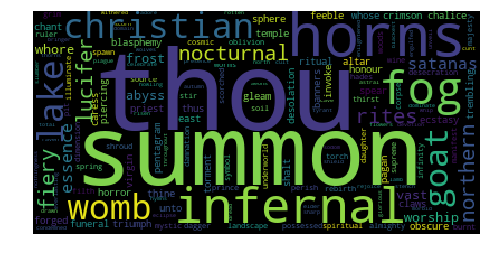

death


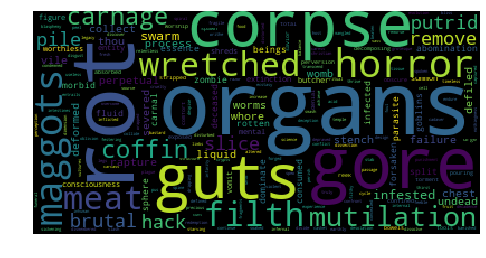

heavy


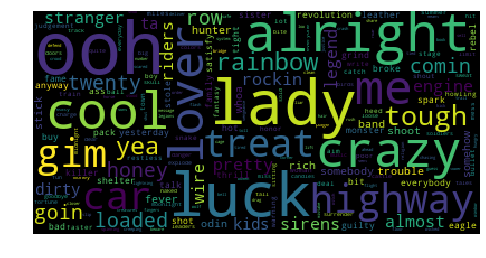

power


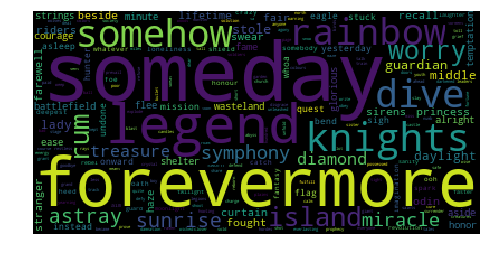

thrash


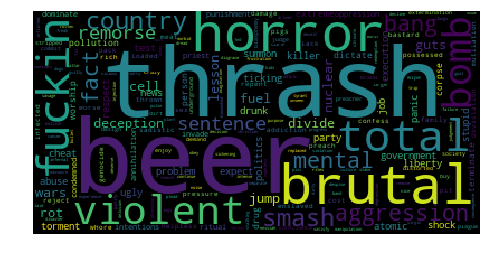

other


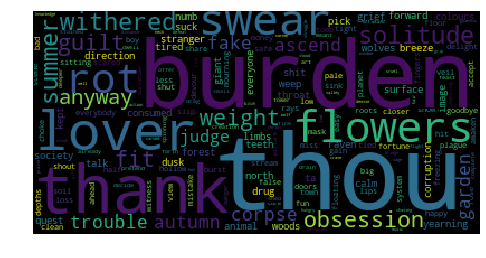

In [230]:
stemmer = PorterStemmer()
stemmed_corpus = []
original_corpus = []
for text in genre_texts:
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens]
    stemmed_corpus.append(stemmed)
    original_corpus.append(tokens)
dictionary = Dictionary(stemmed_corpus)
vectors = [dictionary.doc2bow(text) for text in stemmed_corpus]
vectors = [[bow_repr for bow_repr in vector if bow_repr[1] > 100] for vector in vectors]
tfidf = TfidfModel(vectors, wglobal=lambda x1, x2: np.log2((1 + x2) / (1 + x1)))
surface_forms = get_common_surface_form(original_corpus, stemmer)
for i, genre in enumerate(genres):
    print(genre)
    top_words = np.sort(np.array(tfidf[vectors[i]], dtype = [('word', int), ('score', float)]), order='score')[::-1]
    frequencies = [(surface_forms[dictionary[word]],score) for word,score in top_words]
    wc = wordcloud.WordCloud(stopwords=sorted(stop_words)).generate_from_frequencies(dict(frequencies))
    plt.figure(figsize=(8, 5))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()